<center><h1>CHINTHAKINDI_RAJA SHAKER_FINAL_PROJECT</h1></center>

Name: CHINTHAKINDI RAJA SHAKER
<br>
Github Username: rajashakerchinthakindi
<br>
USC ID: 7325565039

# Importing Libraries

In [5]:
import os
import cv2
import time
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, auc
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Data Exploration and Pre-processing

#### Loading Dataset

In [8]:
main_directory = "../data/RealWaste/"
image_dimensions_taken = (224, 224)
split_ratio = 0.8
random.seed(42)

directory_folder = sorted([f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))])
classes = {name: i for i, name in enumerate(directory_folder)}

train_x, train_y = [], []
test_x, test_y = [], []

def process(img_list, path, label):
    image_list = []
    for file_name_information in img_list:
        file_path_information = os.path.join(path, file_name_information)
        img = cv2.imread(file_path_information)
        if img is not None:
            img = cv2.resize(img, image_dimensions_taken)
            image_list.append(img)
    lbls = [label] * len(image_list)
    return image_list, lbls

for tagging in directory_folder:
    p = os.path.join(main_directory, tagging)
    files = sorted(os.listdir(p))
    idx = classes[tagging]
    cut = int(len(files) * split_ratio)
    tr_set, tr_lbl = process(files[:cut], p, idx)
    te_set, te_lbl = process(files[cut:], p, idx)
    train_x += tr_set
    train_y += tr_lbl
    test_x += te_set
    test_y += te_lbl

train_x = np.array(train_x)
test_x = np.array(test_x)

enc = OneHotEncoder(sparse_output=False)
train_y = enc.fit_transform(np.array(train_y).reshape(-1, 1))
test_y = enc.transform(np.array(test_y).reshape(-1, 1))

print("Train X:", train_x.shape, "Train Y:", train_y.shape)
print("Test X:", test_x.shape, "Test Y:", test_y.shape)

Train X: (3798, 224, 224, 3) Train Y: (3798, 9)
Test X: (954, 224, 224, 3) Test Y: (954, 9)


In [9]:
class_names = [name for name, _ in sorted(classes.items(), key=lambda x: x[1])]
print("Class names:", class_names)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

Class names: ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']
(3798, 224, 224, 3) (3798, 9)
(954, 224, 224, 3) (954, 9)


#### Data Visualization

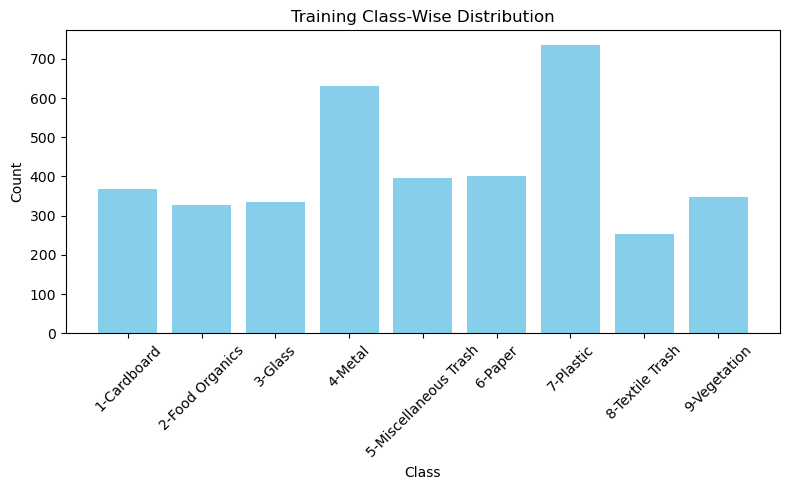

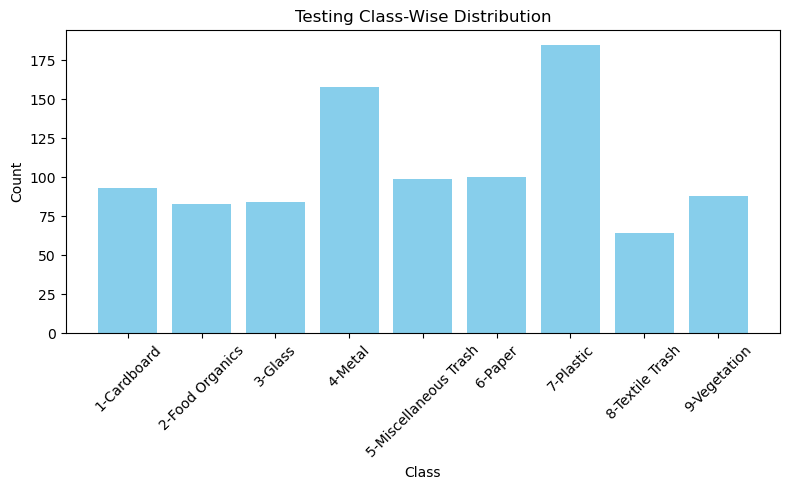

In [11]:
index_information_classes = {v: k for k, v in classes.items()}

label_train_information = [index_information_classes[np.argmax(label)] for label in train_y]
label_test_information = [index_information_classes[np.argmax(label)] for label in test_y]

def plot_distribution(labels, title):
    new, number = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 5))
    plt.bar(new, number, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_distribution(label_train_information, "Training Class-Wise Distribution")
plot_distribution(label_test_information, "Testing Class-Wise Distribution")

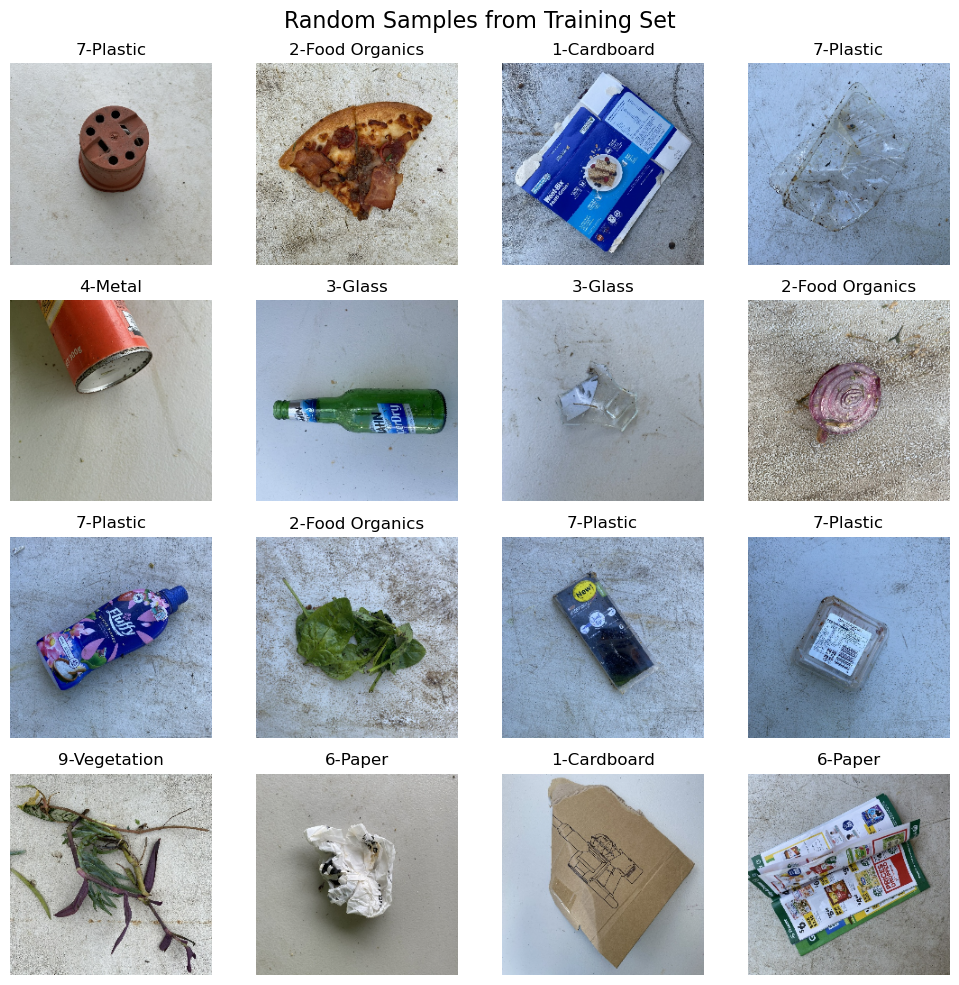

In [12]:
plt.figure(figsize=(10, 10))
i = 0
while i < 16:
    idx = random.randint(0, len(train_x) - 1)
    plt.subplot(4, 4, i + 1)
    plt.imshow(cv2.cvtColor(train_x[idx], cv2.COLOR_BGR2RGB))
    label_idx = np.argmax(train_y[idx])
    label = index_information_classes[label_idx]
    plt.title(label)
    plt.axis('off')
    i += 1

plt.suptitle("Random Samples from Training Set", fontsize=16)
plt.tight_layout()
plt.show()

# 2. Transfer Learning

#### Data augmentation

In [15]:
def get_data_augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.1),
    ])

#### Model Building

In [17]:
def layer_information(pre_trained_base, input_shape, num_classes):
    base_model = pre_trained_base(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    augmentation = get_data_augmentation_layer()
    inputs = Input(shape=input_shape)
    x = augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [18]:
def evaluate_model(model, X, y_true, dataset_name="Set", class_names=None, show_cm=True):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)

    precision = precision_score(y_true_labels, y_pred, average='macro')
    recall = recall_score(y_true_labels, y_pred, average='macro')
    f1 = f1_score(y_true_labels, y_pred, average='macro')

    try:
        auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr', average='macro')
    except ValueError:
        auc = float('nan')

    n_classes = y_true.shape[1]
    fpr_dict = {}
    tpr_dict = {}

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        label = class_names[i] if class_names else f'Class {i}'
        fpr_dict[label] = fpr
        tpr_dict[label] = tpr

    cm = confusion_matrix(y_true_labels, y_pred)
    if show_cm:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names if class_names else np.arange(n_classes),
                    yticklabels=class_names if class_names else np.arange(n_classes))
        plt.title(f'Confusion Matrix - {dataset_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

    print(f"--- {dataset_name} ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}\n")

    return {"Precision": precision, "Recall": recall, "F1": f1, "AUC": auc, "FPR": fpr_dict, "TPR": tpr_dict, "ConfusionMatrix": cm}

In [19]:
def plot_training_history(history_obj):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(12, 4))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history_obj.history[metric], label=f'Train {metric}')
        plt.plot(history_obj.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [20]:
X_train_final, X_val, y_train_final, y_val = train_test_split(train_x, train_y, test_size=0.2, stratify=train_y, random_state=42)

#### ResNet50

In [22]:
model = layer_information(ResNet50, input_shape=(224, 224, 3), num_classes= 9)
model.summary()

I0000 00:00:1753772347.346028   17387 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753772347.346418   17387 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,859,849 (91.02 MB)

 Trainable params: 267,785 (1.02 MB)

 Non-trainable params: 23,592,064 (90.00 MB)

In [23]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping_info = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_info = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint = ModelCheckpoint("../models/best_model_resnet50.keras", monitor='val_loss', save_best_only=True)
start_time = time.time()
history = model.fit(X_train_final, y_train_final ,validation_data=(X_val, y_val),epochs=100, batch_size=8, callbacks=[early_stopping_info, reduce_info, checkpoint],verbose=1)
end_time = time.time()
training_duration_resnet_50 = end_time - start_time

Epoch 1/100


E0000 00:00:1753772349.210007   17387 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


380/380 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.2742 - loss: 4.6627 - val_accuracy: 0.5526 - val_loss: 3.6284 - learning_rate: 1.0000e-04
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.5682 - loss: 3.6224 - val_accuracy: 0.6237 - val_loss: 3.3487 - learning_rate: 1.0000e-04
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.6251 - loss: 3.3398 - val_accuracy: 0.6711 - val_loss: 3.1316 - learning_rate: 1.0000e-04
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6515 - loss: 3.1590 - val_accuracy: 0.7039 - val_loss: 2.9167 - learning_rate: 1.0000e-04
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.6921 - loss: 2.9374 - val_accuracy: 0.7171 - val_loss: 2.7751 - learning_rate: 1.0000e-04
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.7096 - loss: 2.8083 - val_accuracy: 0.7224 - val_loss: 2.6580 - learning_rate: 1.0000e-04
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - a

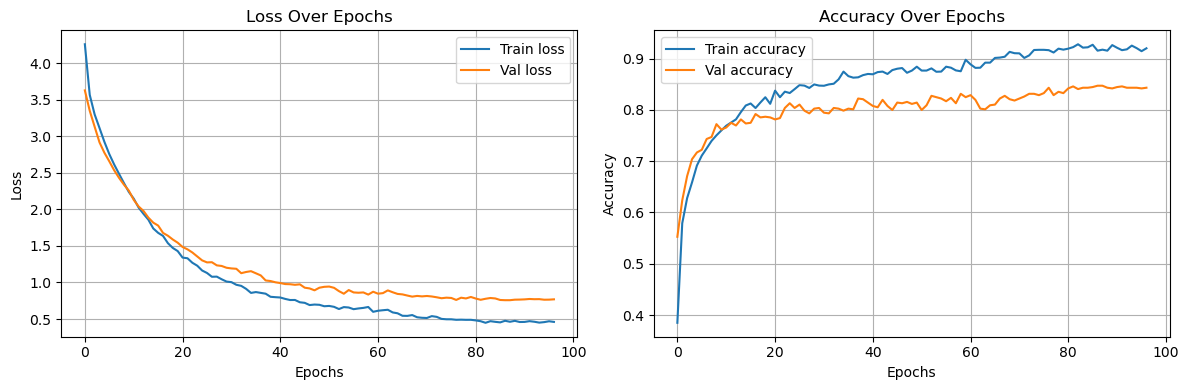

In [24]:
plot_training_history(history)

E0000 00:00:1753774121.162327   17387 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step


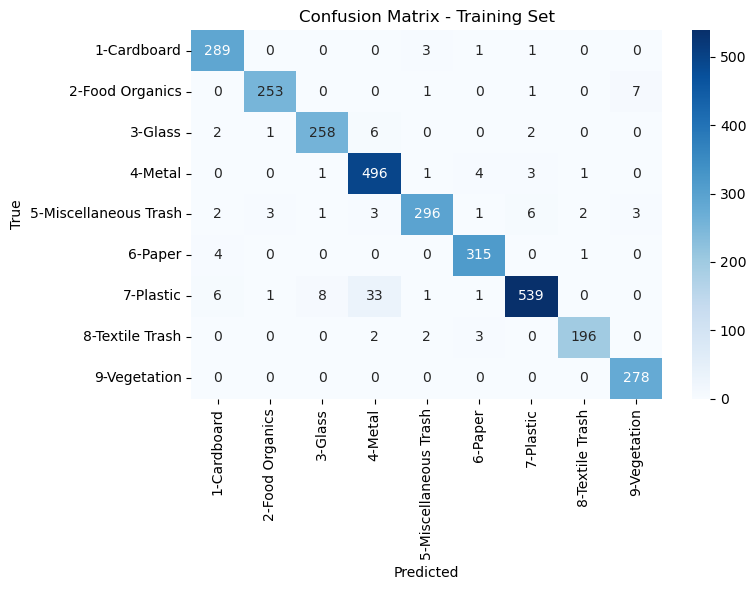

--- Training Set ---
Precision: 0.9645
Recall:    0.9652
F1 Score:  0.9645
AUC:       0.9992



In [25]:
results_train_resnet50 = evaluate_model(model, X_train_final, y_train_final, dataset_name="Training Set", class_names=class_names)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step


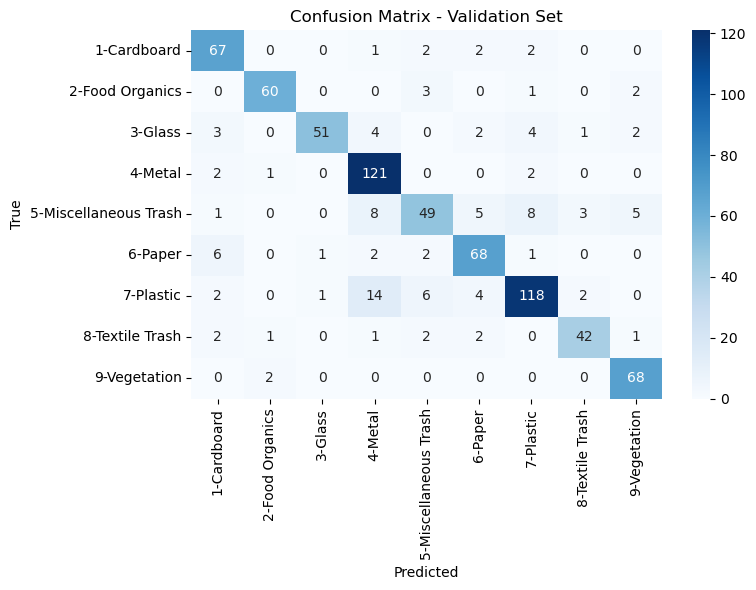

--- Validation Set ---
Precision: 0.8564
Recall:    0.8449
F1 Score:  0.8468
AUC:       0.9850



In [26]:
results_val_resnet50 = evaluate_model(model, X_val, y_val, dataset_name="Validation Set", class_names=class_names)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step


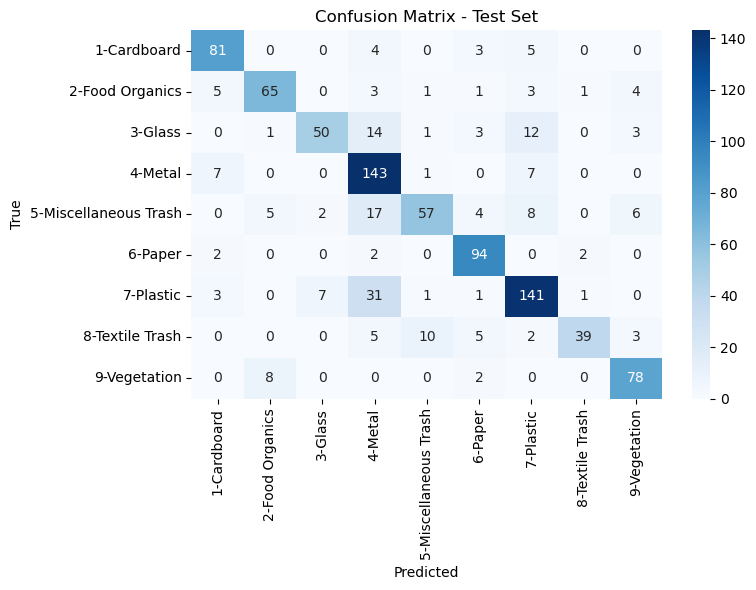

--- Test Set ---
Precision: 0.8126
Recall:    0.7698
F1 Score:  0.7805
AUC:       0.9737



In [27]:
results_test_resnet50 = evaluate_model(model, test_x, test_y, dataset_name="Test Set", class_names=class_names)

<h4> Results for ResNet50: </h4>
<ul> <li><b>Training Set:</b> ResNet50 performed exceptionally well on the training data, achieving a high precision of <b>0.9645</b> and recall of <b>0.9652</b>. This led to an F1 score of <b>0.9645</b>, indicating excellent balance between precision and recall. The AUC of <b>0.9992</b> suggests that the model is able to separate classes with near-perfect accuracy during training.</li> <li><b>Validation Set:</b> On unseen validation data, ResNet50 maintained strong performance with a precision of <b>0.8564</b> and a recall of <b>0.8449</b>, leading to an F1 score of <b>0.8468</b>. The AUC dropped slightly to <b>0.9850</b>, which is still a very good indicator of generalization and class separability, though it shows mild overfitting compared to training results.</li> <li><b>Test Set:</b> The test set results confirm the model's generalization capability, with a precision of <b>0.8126</b>, recall of <b>0.7698</b>, and F1 score of <b>0.7805</b>. While there's a noticeable decline compared to validation metrics, the AUC of <b>0.9737</b> remains strong, demonstrating that the model still performs reliably across classes.</li> </ul>

#### ResNet101

In [30]:
model = layer_information(ResNet101, input_shape=(224, 224, 3), num_classes= 9)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,930,313 (163.77 MB)

 Trainable params: 267,785 (1.02 MB)

 Non-trainable params: 42,662,528 (162.74 MB)

In [31]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping_info = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_info = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint = ModelCheckpoint("../models/best_model_resnet101.keras", monitor='val_loss', save_best_only=True)
start_time = time.time()
history = model.fit(X_train_final, y_train_final ,validation_data=(X_val, y_val),epochs=100, batch_size=8, callbacks=[early_stopping_info, reduce_info, checkpoint],verbose=1)
end_time = time.time()
training_duration_resnet_101 = end_time - start_time

Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.2795 - loss: 4.6824 - val_accuracy: 0.6079 - val_loss: 3.5193 - learning_rate: 1.0000e-04
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.5502 - loss: 3.6219 - val_accuracy: 0.6724 - val_loss: 3.2558 - learning_rate: 1.0000e-04
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.6101 - loss: 3.3412 - val_accuracy: 0.6934 - val_loss: 3.0821 - learning_rate: 1.0000e-04
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.6599 - loss: 3.1424 - val_accuracy: 0.7224 - val_loss: 2.9167 - learning_rate: 1.0000e-04
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.6794 - loss: 2.9625 - val_accuracy: 0.7382 - val_loss: 2.7798 - learning_rate: 1.0000e-04
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.7139 - loss: 2.7843 - val_accuracy: 0.7474 - val_loss: 2.6128 - learning_rate: 1.0000e-04
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 27s 7

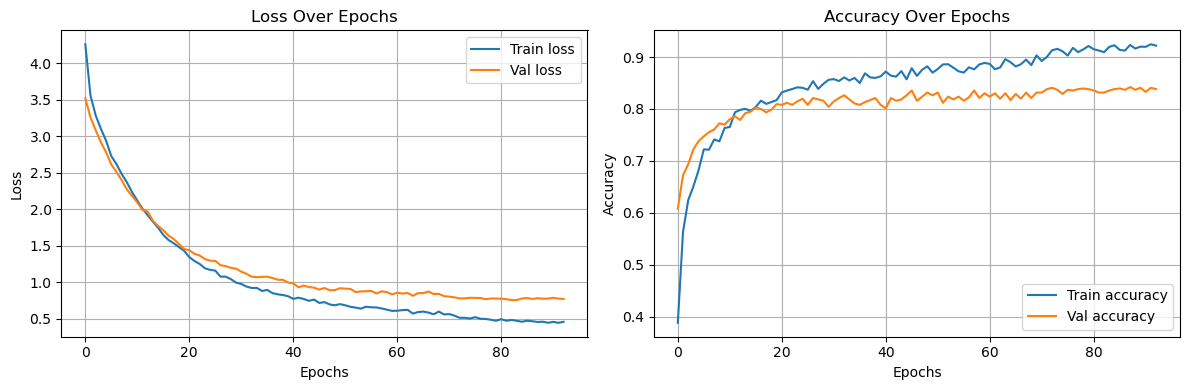

In [32]:
plot_training_history(history)

E0000 00:00:1753776618.267862   17387 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step


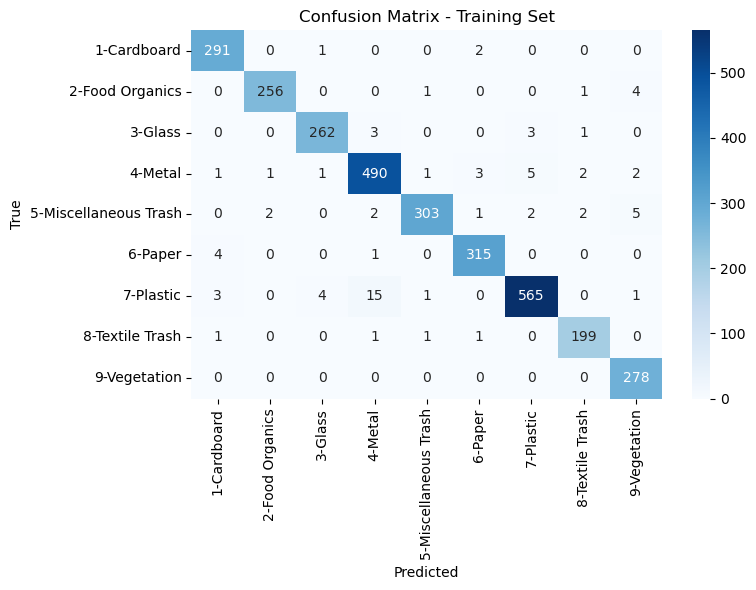

--- Training Set ---
Precision: 0.9745
Recall:    0.9766
F1 Score:  0.9754
AUC:       0.9995



In [33]:
results_train_resnet101 = evaluate_model(model, X_train_final, y_train_final, dataset_name="Training Set", class_names=class_names)

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step


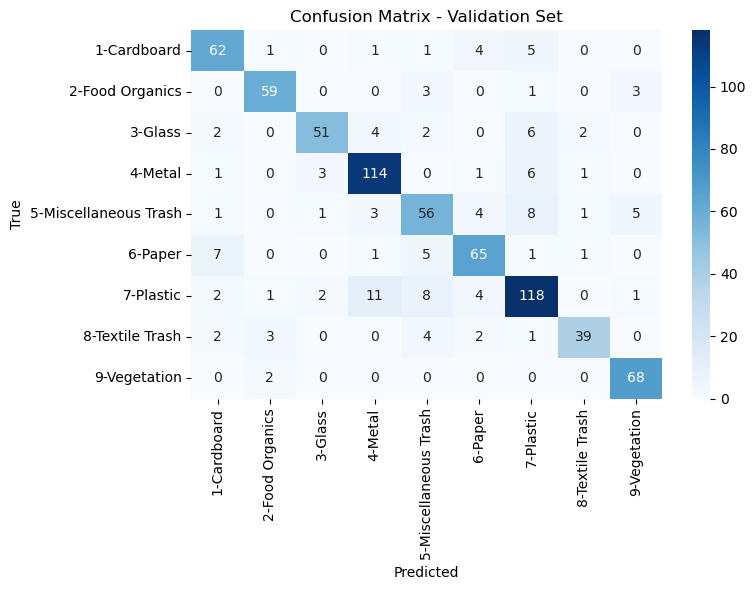

--- Validation Set ---
Precision: 0.8382
Recall:    0.8287
F1 Score:  0.8320
AUC:       0.9814



In [34]:
results_val_resnet101 = evaluate_model(model, X_val, y_val, dataset_name="Validation Set", class_names=class_names)

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step


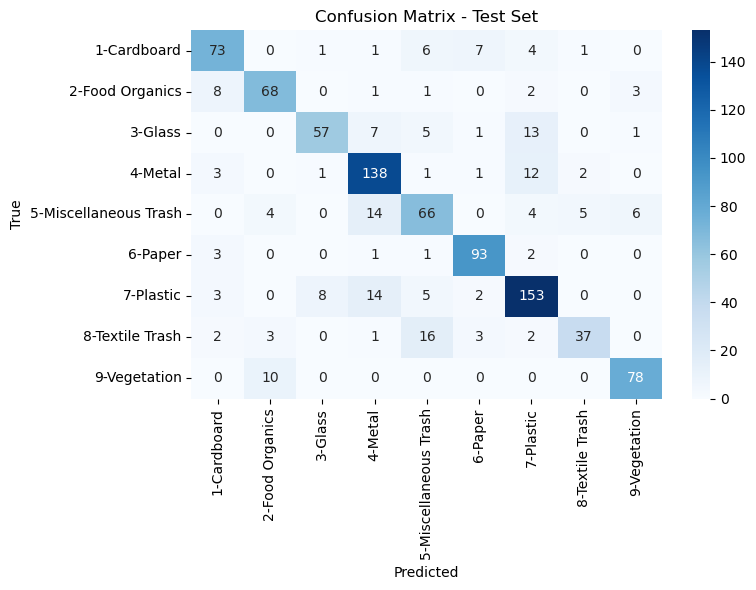

--- Test Set ---
Precision: 0.8058
Recall:    0.7827
F1 Score:  0.7903
AUC:       0.9749



In [35]:
results_test_resnet101 = evaluate_model(model, test_x, test_y, dataset_name="Test Set", class_names=class_names)

<h4> Results for ResNet101: </h4>
<ul> <li><b>Note:</b> I was instructed to use <b>ResNet100</b>, but due to availability and compatibility within the TensorFlow/Keras library, I used <b>ResNet101</b>, which is a closely related and widely supported variant with deeper layers.</li> <li><b>Training Set:</b> ResNet101 achieved outstanding results on the training set with a precision of <b>0.9745</b> and a recall of <b>0.9766</b>, resulting in an F1 score of <b>0.9754</b>. The AUC score of <b>0.9995</b> reflects near-perfect classification performance during training, suggesting that the model effectively learned the patterns in the dataset.</li> <li><b>Validation Set:</b> On the validation set, the model performed strongly, achieving a precision of <b>0.8382</b> and a recall of <b>0.8287</b>. The resulting F1 score of <b>0.8320</b> shows a slight drop from training but still indicates solid generalization. The AUC score of <b>0.9814</b> confirms that the model retains good discriminative ability on unseen validation data.</li> <li><b>Test Set:</b> On the final test set, ResNet101 maintained competitive performance with a precision of <b>0.8058</b>, recall of <b>0.7827</b>, and F1 score of <b>0.7903</b>. The AUC of <b>0.9749</b> further supports the model’s ability to separate the classes effectively in real-world unseen data.</li> </ul>

#### EfficientNetB0

In [38]:
model = layer_information(EfficientNetB0, input_shape=(224, 224, 3), num_classes= 9)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,220,332 (16.10 MB)

 Trainable params: 167,945 (656.04 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

In [39]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping_info = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_info = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint = ModelCheckpoint("../models/best_model_EfficientNetB0.keras", monitor='val_loss', save_best_only=True)
start_time = time.time()
history = model.fit(X_train_final, y_train_final ,validation_data=(X_val, y_val),epochs=100, batch_size=8, callbacks=[early_stopping_info, reduce_info, checkpoint],verbose=1)
end_time = time.time()
training_duration_EfficientNetB0 = end_time - start_time

Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.2190 - loss: 4.8528 - val_accuracy: 0.4974 - val_loss: 3.7277 - learning_rate: 1.0000e-04
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.4650 - loss: 3.8091 - val_accuracy: 0.5947 - val_loss: 3.3873 - learning_rate: 1.0000e-04
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.5500 - loss: 3.4979 - val_accuracy: 0.6618 - val_loss: 3.1237 - learning_rate: 1.0000e-04
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.6057 - loss: 3.2448 - val_accuracy: 0.6934 - val_loss: 2.9537 - learning_rate: 1.0000e-04
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.6586 - loss: 2.9976 - val_accuracy: 0.7224 - val_loss: 2.8013 - learning_rate: 1.0000e-04
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.6702 - loss: 2.8686 - val_accuracy: 0.7263 - val_loss: 2.6682 - learning_rate: 1.0000e-04
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 17s 4

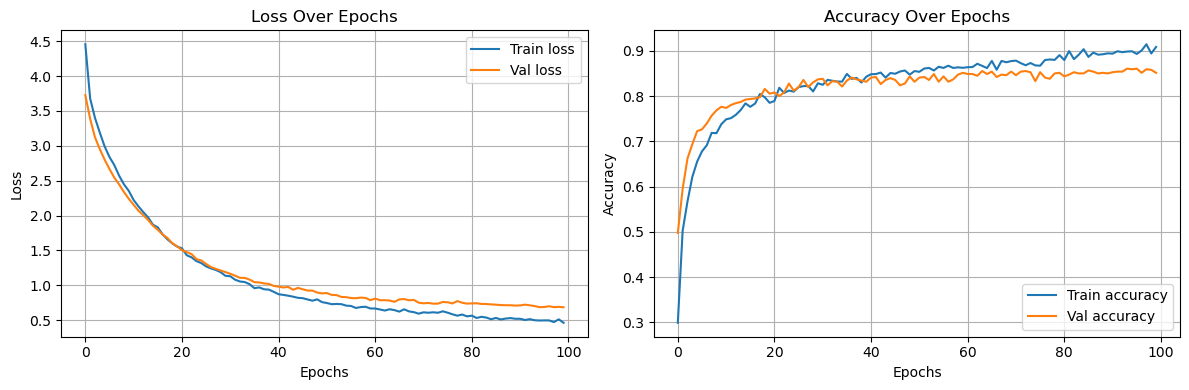

In [40]:
plot_training_history(history)

E0000 00:00:1753778270.334629   17387 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step


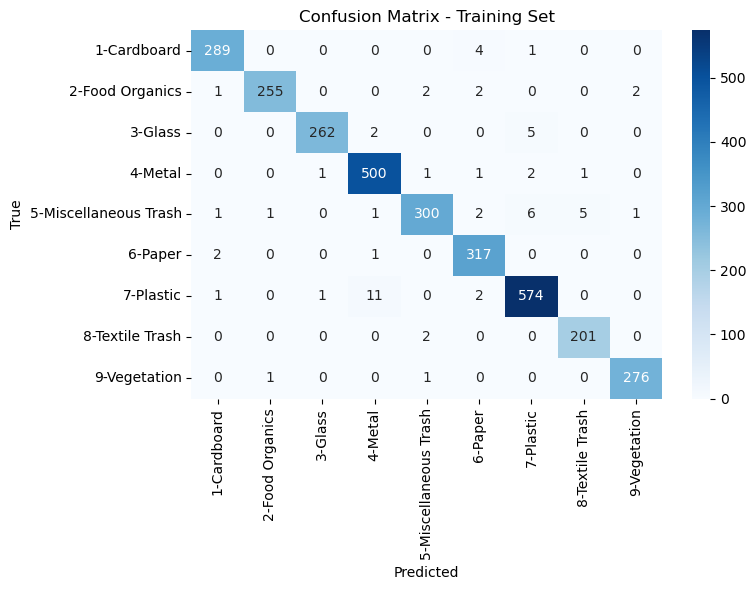

--- Training Set ---
Precision: 0.9802
Recall:    0.9792
F1 Score:  0.9796
AUC:       0.9997



In [41]:
results_train_EfficientNetB0 = evaluate_model(model, X_train_final, y_train_final, dataset_name="Training Set", class_names=class_names)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


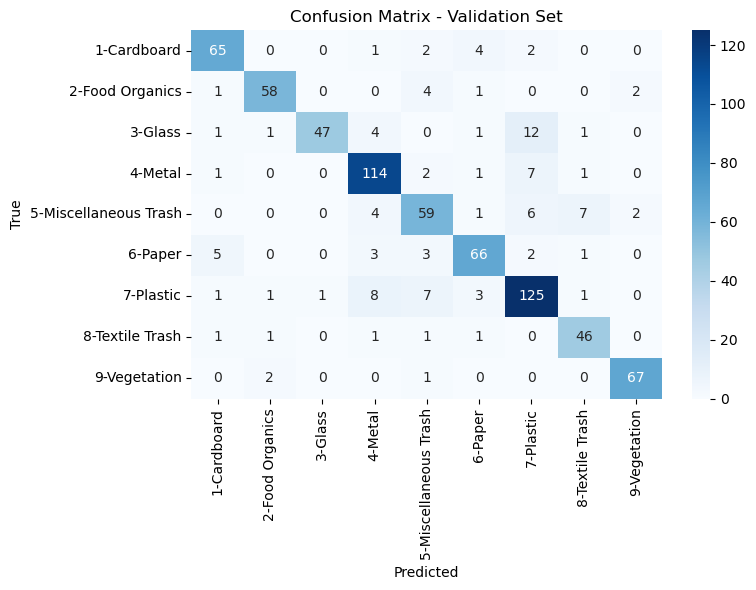

--- Validation Set ---
Precision: 0.8629
Recall:    0.8494
F1 Score:  0.8531
AUC:       0.9844



In [42]:
results_val_EfficientNetB0 = evaluate_model(model, X_val, y_val, dataset_name="Validation Set", class_names=class_names)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


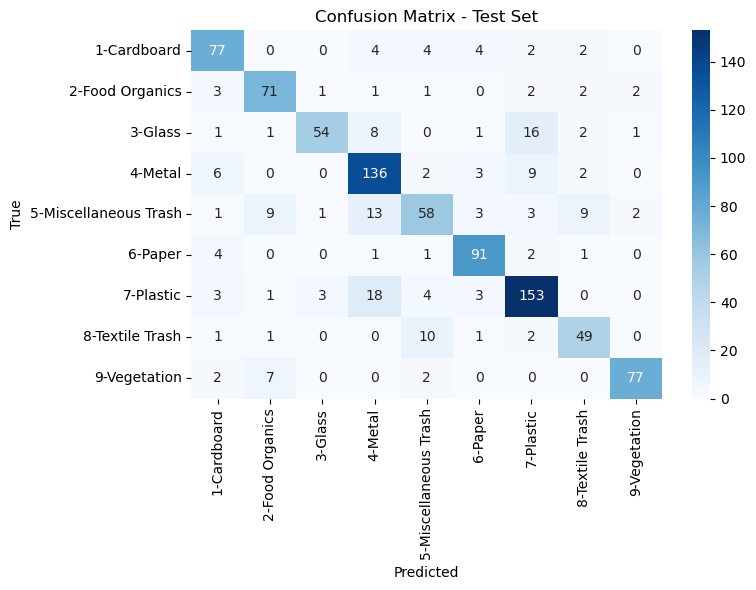

--- Test Set ---
Precision: 0.8097
Recall:    0.7945
F1 Score:  0.7979
AUC:       0.9764



In [43]:
results_test_EfficientNetB0 = evaluate_model(model, test_x, test_y, dataset_name="Test Set", class_names=class_names)

<h4> Results for EfficientNetB0: </h4>
<ul> <li><b>Training Set:</b> EfficientNetB0 delivered exceptional performance on the training set with a precision of <b>0.9802</b> and a recall of <b>0.9792</b>, resulting in a highly balanced F1 score of <b>0.9796</b>. The AUC score of <b>0.9997</b> indicates that the model nearly perfectly distinguished between classes during training.</li> <li><b>Validation Set:</b> On the validation data, the model achieved a precision of <b>0.8629</b> and a recall of <b>0.8494</b>, resulting in an F1 score of <b>0.8531</b>. These values reflect strong generalization with slightly better precision-recall trade-off than ResNet50 and ResNet101. The AUC of <b>0.9844</b> suggests very effective class separation on unseen data.</li> <li><b>Test Set:</b> On the test set, EfficientNetB0 continued to perform robustly with a precision of <b>0.8097</b> and a recall of <b>0.7945</b>, producing an F1 score of <b>0.7979</b>. The AUC score of <b>0.9764</b> confirms that the model maintains reliable classification ability even under final evaluation.</li> </ul>

#### VGG16

In [46]:
model = layer_information(VGG16, input_shape=(224, 224, 3), num_classes= 9)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,784,073 (56.40 MB)

 Trainable params: 68,105 (266.04 KB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [47]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping_info = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_info = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint = ModelCheckpoint("../models/best_model_VGG16.keras", monitor='val_loss', save_best_only=True)
start_time = time.time()
history = model.fit(X_train_final, y_train_final ,validation_data=(X_val, y_val),epochs=100, batch_size=8, callbacks=[early_stopping_info, reduce_info, checkpoint],verbose=1)
end_time = time.time()
training_duration_VGG16 = end_time - start_time

Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.1496 - loss: 4.8925 - val_accuracy: 0.3605 - val_loss: 3.9759 - learning_rate: 1.0000e-04
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.3186 - loss: 4.0049 - val_accuracy: 0.4803 - val_loss: 3.4812 - learning_rate: 1.0000e-04
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.4389 - loss: 3.5927 - val_accuracy: 0.5513 - val_loss: 3.2271 - learning_rate: 1.0000e-04
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.4863 - loss: 3.3537 - val_accuracy: 0.6000 - val_loss: 3.0236 - learning_rate: 1.0000e-04
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.5456 - loss: 3.1414 - val_accuracy: 0.6421 - val_loss: 2.8662 - learning_rate: 1.0000e-04
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.5508 - loss: 3.0656 - val_accuracy: 0.6553 - val_loss: 2.7271 - learning_rate: 1.0000e-04
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 24s 6

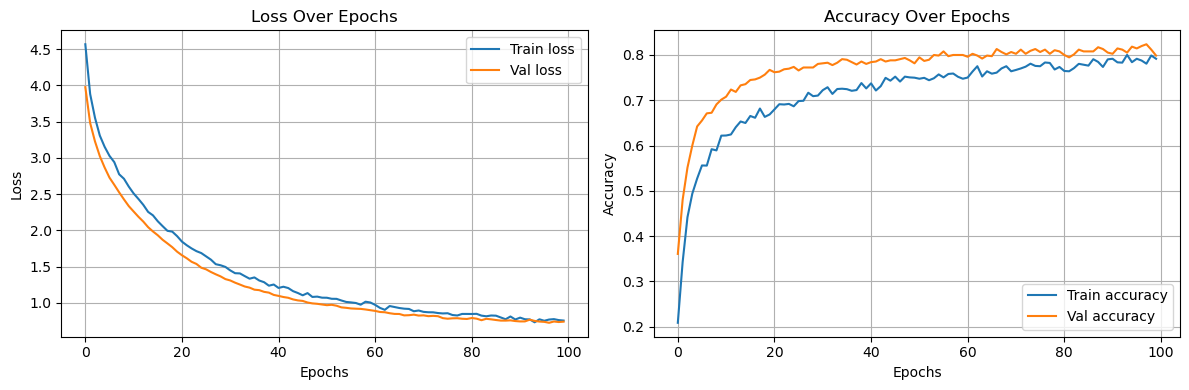

In [48]:
plot_training_history(history)

E0000 00:00:1753780730.280060   17387 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step


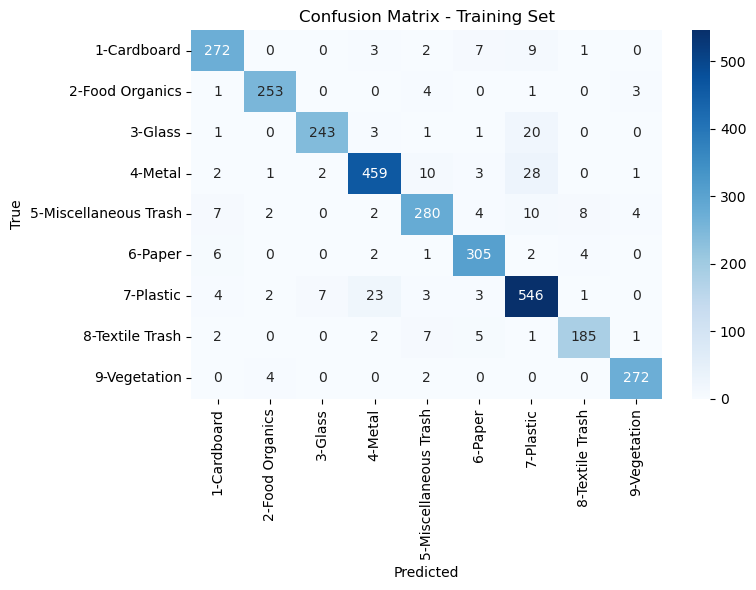

--- Training Set ---
Precision: 0.9330
Recall:    0.9283
F1 Score:  0.9304
AUC:       0.9963



In [49]:
results_train_VGG16 = evaluate_model(model, X_train_final, y_train_final, dataset_name="Training Set", class_names=class_names)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step


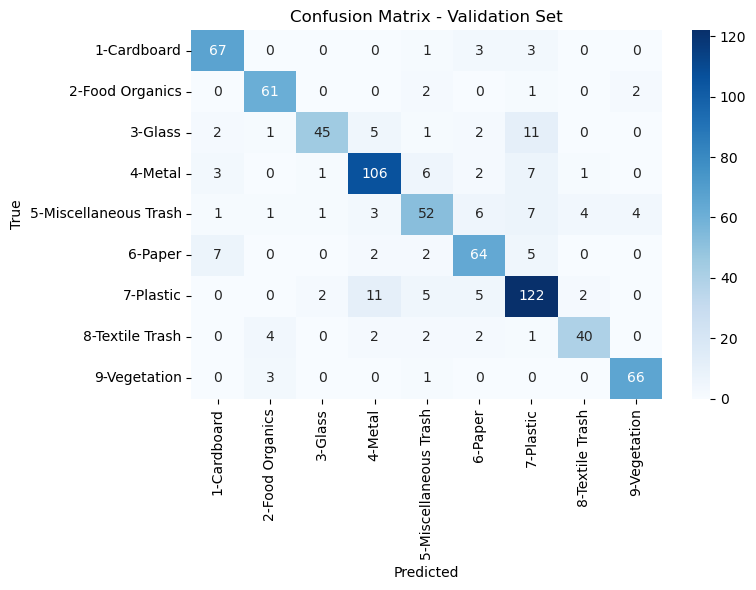

--- Validation Set ---
Precision: 0.8309
Recall:    0.8175
F1 Score:  0.8214
AUC:       0.9770



In [50]:
results_val_VGG16 = evaluate_model(model, X_val, y_val, dataset_name="Validation Set", class_names=class_names)

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step


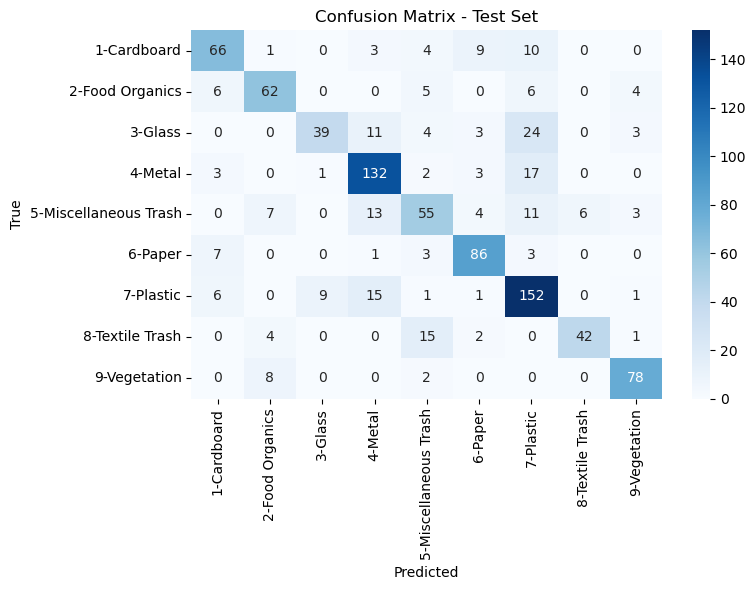

--- Test Set ---
Precision: 0.7645
Recall:    0.7262
F1 Score:  0.7375
AUC:       0.9675



In [51]:
results_test_VGG16 = evaluate_model(model, test_x, test_y, dataset_name="Test Set", class_names=class_names)

<h4> Results for VGG16: </h4>
<ul> <li><b>Training Set:</b> VGG16 demonstrated solid learning capability on the training data, achieving a precision of <b>0.9330</b> and recall of <b>0.9283</b>, with an F1 score of <b>0.9304</b>. The AUC of <b>0.9963</b> indicates that the model can distinguish classes well within the training domain, though slightly less so compared to deeper models like ResNet or EfficientNet.</li> <li><b>Validation Set:</b> On validation data, the model showed reasonable generalization with a precision of <b>0.8309</b> and recall of <b>0.8175</b>, leading to an F1 score of <b>0.8214</b>. The AUC of <b>0.9770</b> is still strong, but lower than the other models, suggesting some limitations in how VGG16 captures generalizable features.</li> <li><b>Test Set:</b> On the final test set, VGG16 delivered the lowest performance among all models with a precision of <b>0.7645</b>, recall of <b>0.7262</b>, and F1 score of <b>0.7375</b>. The AUC of <b>0.9675</b> is respectable, but confirms a relatively weaker performance in real-world generalization compared to deeper or more modern architectures.</li> </ul>

# Comparison

#### Metrics Comparison

In [55]:
results = {"Model": [], "Dataset": [], "Precision": [], "Recall": [], "F1 Score": [], "AUC": []}

models = ["ResNet50", "ResNet101", "EfficientNetB0", "VGG16"]
datasets = ["Training Set", "Validation Set", "Test Set"]

result_dicts = {
    "ResNet50": [results_train_resnet50, results_val_resnet50, results_test_resnet50],
    "ResNet101": [results_train_resnet101, results_val_resnet101, results_test_resnet101],
    "EfficientNetB0": [results_train_EfficientNetB0, results_val_EfficientNetB0, results_test_EfficientNetB0],
    "VGG16": [results_train_VGG16, results_val_VGG16, results_test_VGG16],
}

for model_name, result_list in result_dicts.items():
    for dataset_name, result in zip(datasets, result_list):
        results["Model"].append(model_name)
        results["Dataset"].append(dataset_name)
        results["Precision"].append(result["Precision"])
        results["Recall"].append(result["Recall"])
        results["F1 Score"].append(result["F1"])
        results["AUC"].append(result["AUC"])

df_results = pd.DataFrame(results)

In [56]:
df_train = df_results[df_results["Dataset"] == "Training Set"]
df_val = df_results[df_results["Dataset"] == "Validation Set"]
df_test = df_results[df_results["Dataset"] == "Test Set"]

print("Training Set:\n", df_train.drop(columns=["Dataset"]))
print("\nValidation Set:\n", df_val.drop(columns=["Dataset"]))
print("\nTest Set:\n", df_test.drop(columns=["Dataset"]))

Training Set:
             Model  Precision    Recall  F1 Score       AUC
0        ResNet50   0.964474  0.965194  0.964487  0.999153
3       ResNet101   0.974473  0.976557  0.975400  0.999479
6  EfficientNetB0   0.980202  0.979209  0.979616  0.999683
9           VGG16   0.932974  0.928270  0.930401  0.996278

Validation Set:
              Model  Precision    Recall  F1 Score       AUC
1         ResNet50   0.856407  0.844882  0.846803  0.985049
4        ResNet101   0.838186  0.828661  0.831964  0.981360
7   EfficientNetB0   0.862919  0.849411  0.853079  0.984376
10           VGG16   0.830881  0.817543  0.821354  0.977014

Test Set:
              Model  Precision    Recall  F1 Score       AUC
2         ResNet50   0.812591  0.769784  0.780528  0.973692
5        ResNet101   0.805775  0.782711  0.790338  0.974886
8   EfficientNetB0   0.809660  0.794501  0.797915  0.976353
11           VGG16   0.764475  0.726243  0.737492  0.967453


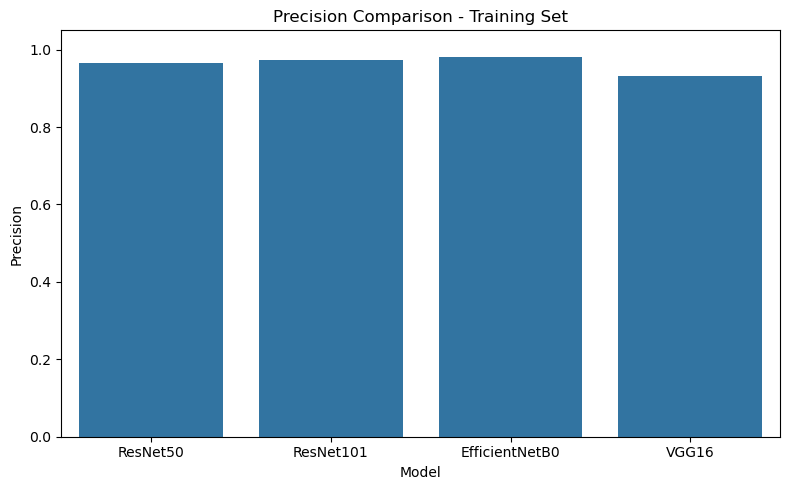

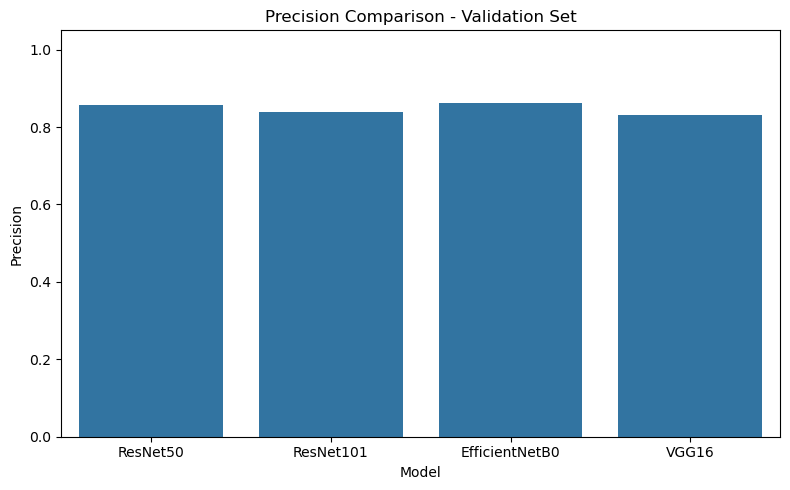

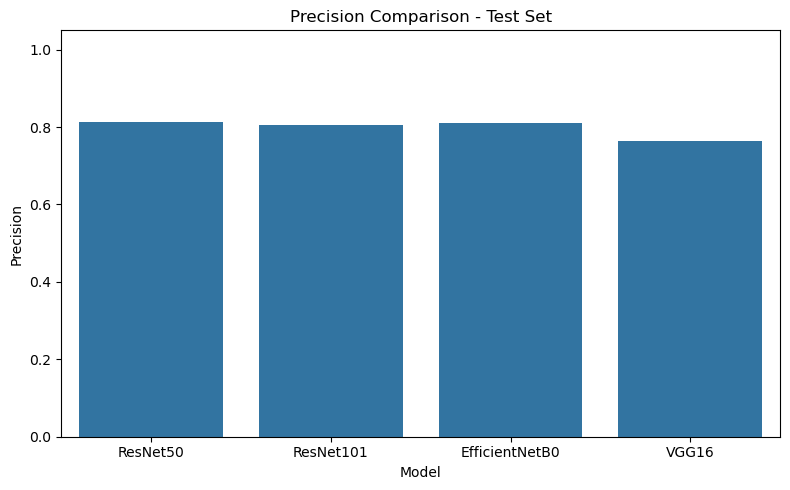

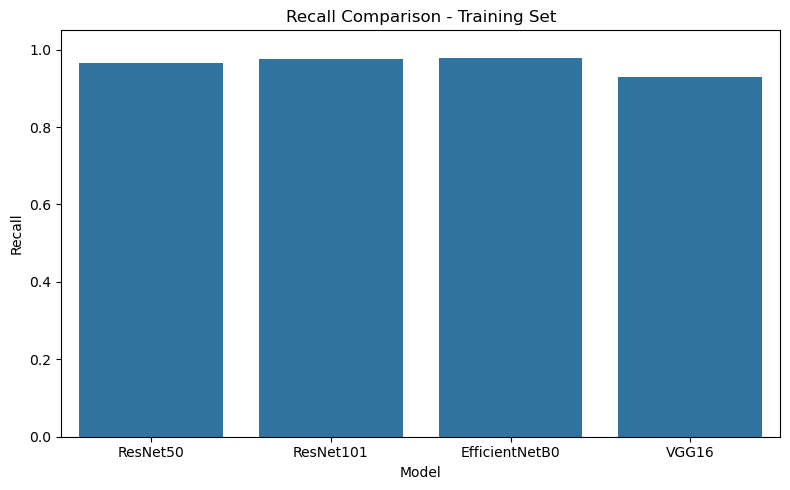

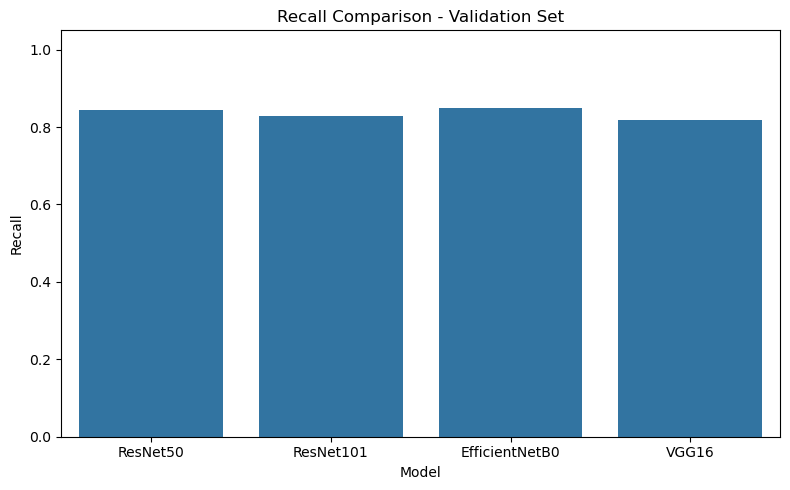

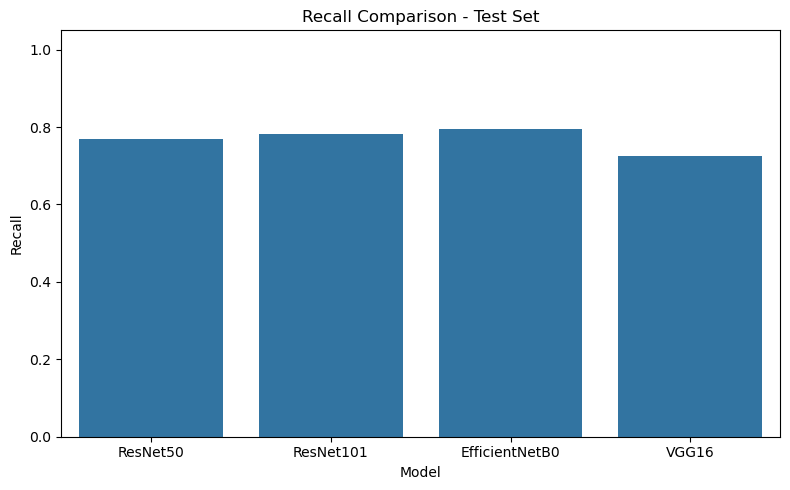

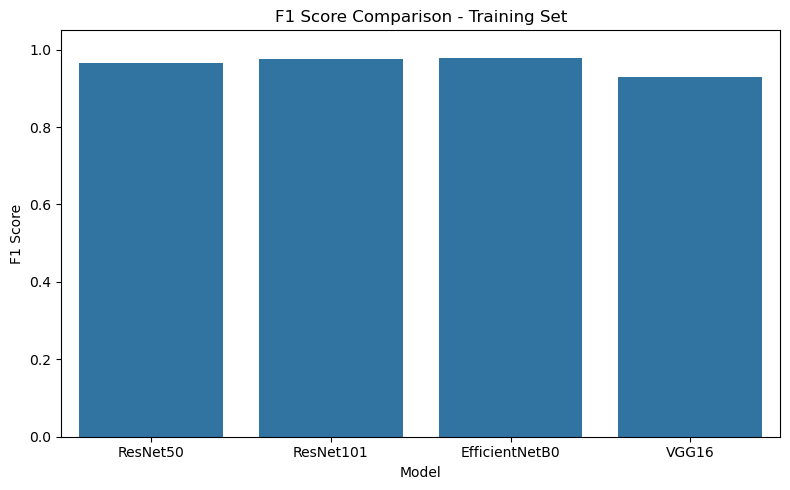

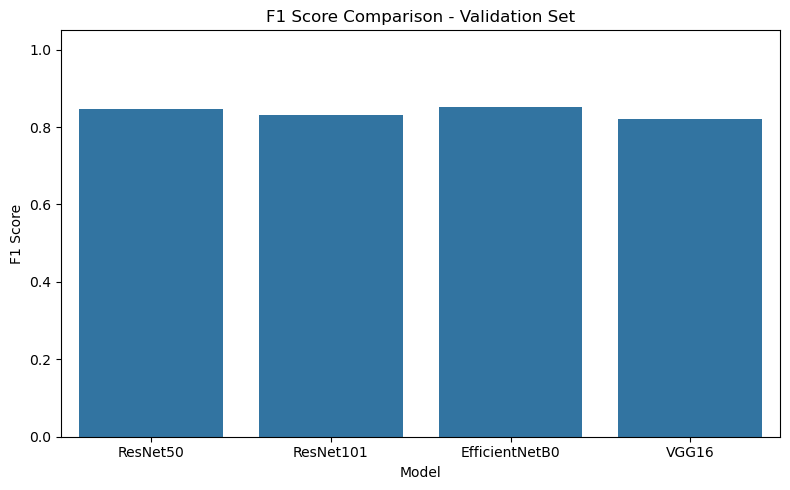

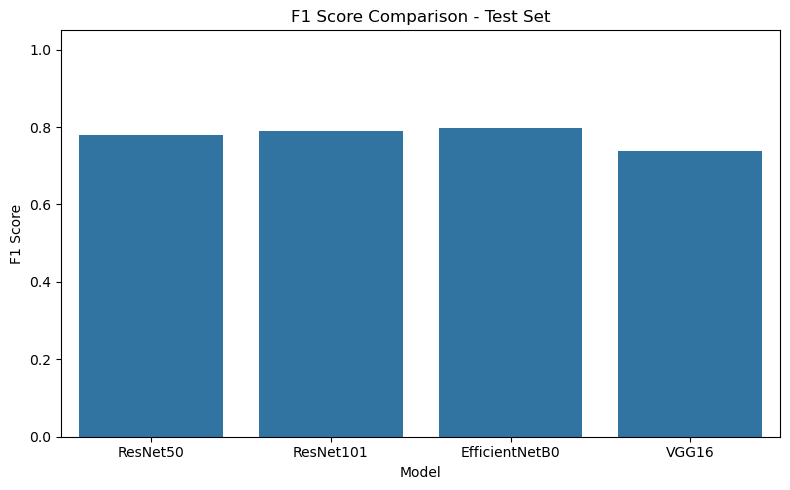

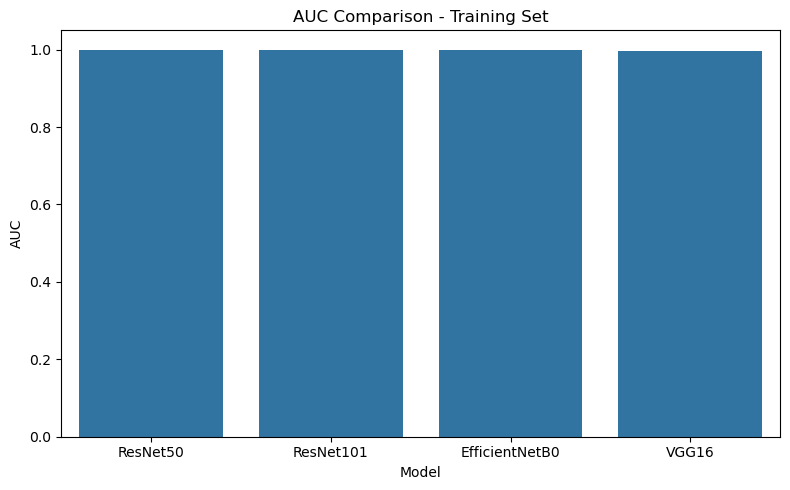

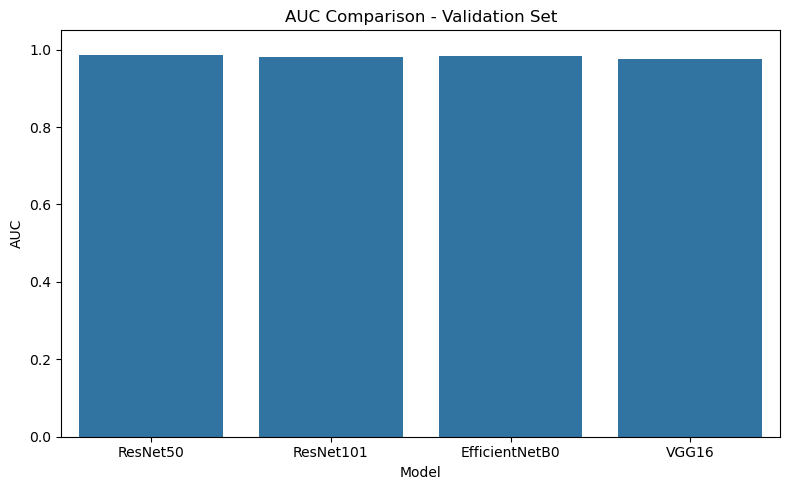

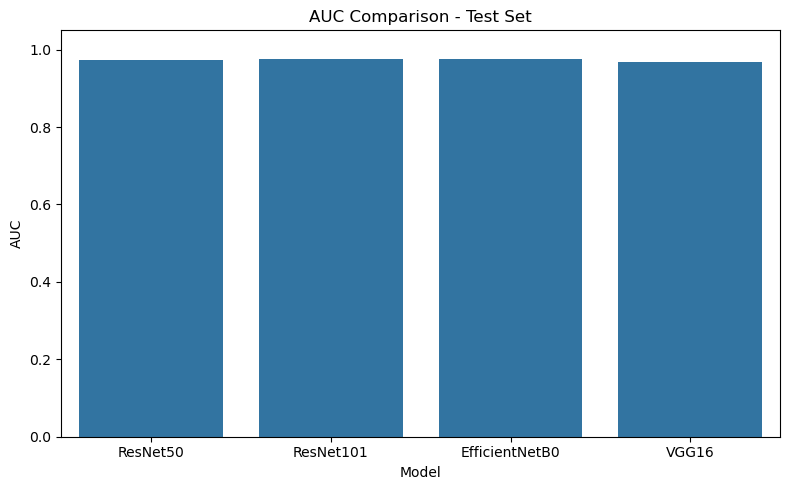

In [57]:
metrics = ["Precision", "Recall", "F1 Score", "AUC"]
datasets = ["Training Set", "Validation Set", "Test Set"]

for metric in metrics:
    for ds in datasets:
        plt.figure(figsize=(8, 5))
        sns.barplot(data=df_results[df_results["Dataset"] == ds], x="Model", y=metric)
        plt.title(f"{metric} Comparison - {ds}")
        plt.ylabel(metric)
        plt.ylim(0, 1.05)
        plt.tight_layout()
        plt.show()

<b>EfficientNetB0 clearly outperforms the other models overall</b>,  it shows the best balance between learning capacity and generalization on both validation and test sets. It is the most reliable model for multi-class classification in this experiment.

#### AUC Comparison

In [60]:
def plot_roc_curves(results_dict, title):
    plt.figure(figsize=(8, 6))
    
    for model_name, result in results_dict.items():
        fpr_dict = result["FPR"]
        tpr_dict = result["TPR"]

        all_fpr = np.unique(np.concatenate(list(fpr_dict.values())))
        mean_tpr = np.zeros_like(all_fpr)

        for fpr, tpr in zip(fpr_dict.values(), tpr_dict.values()):
            mean_tpr += np.interp(all_fpr, fpr, tpr)

        mean_tpr /= len(fpr_dict)
        macro_auc = auc(all_fpr, mean_tpr)

        plt.plot(all_fpr, mean_tpr, label=f"{model_name} (AUC = {macro_auc:.4f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

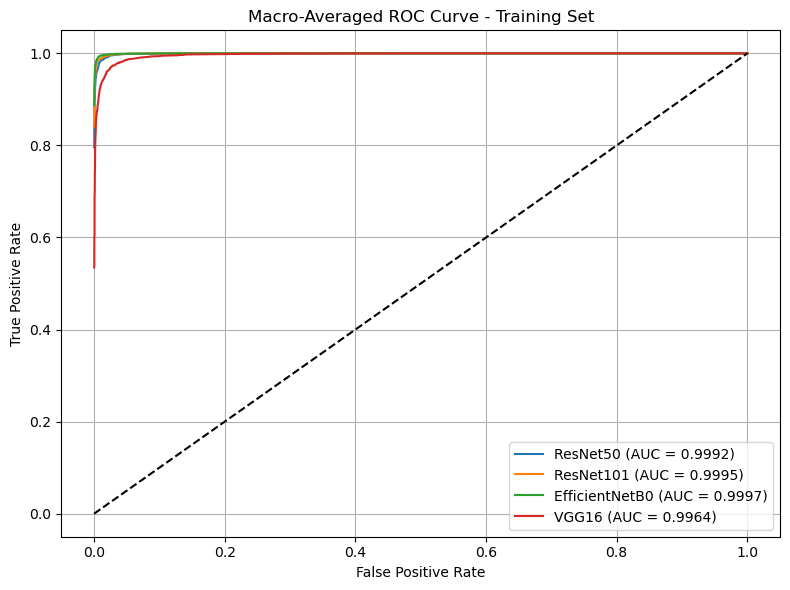

In [61]:
results_train = {
    "ResNet50": results_train_resnet50,
    "ResNet101": results_train_resnet101,
    "EfficientNetB0": results_train_EfficientNetB0,
    "VGG16": results_train_VGG16
}
plot_roc_curves(results_train, title="Macro-Averaged ROC Curve - Training Set")

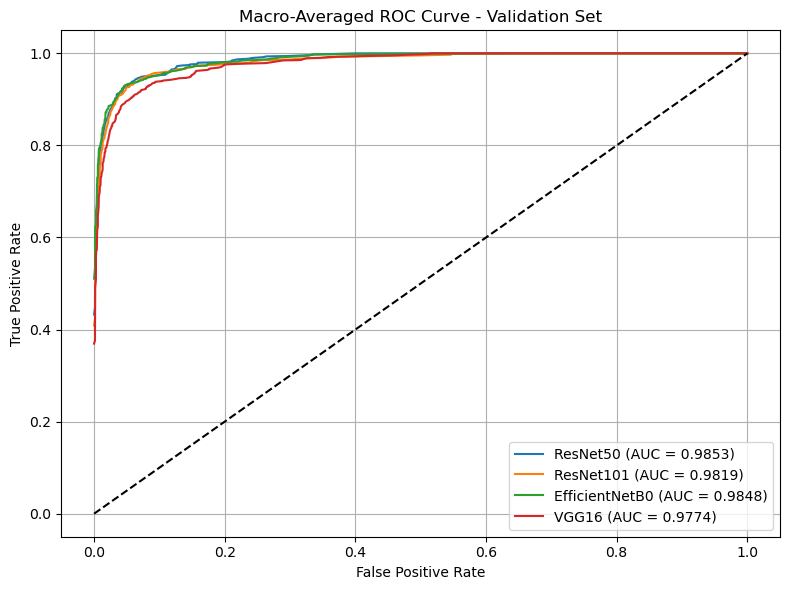

In [62]:
results_val = {
    "ResNet50": results_val_resnet50,
    "ResNet101": results_val_resnet101,
    "EfficientNetB0": results_val_EfficientNetB0,
    "VGG16": results_val_VGG16
}
plot_roc_curves(results_val, title="Macro-Averaged ROC Curve - Validation Set")

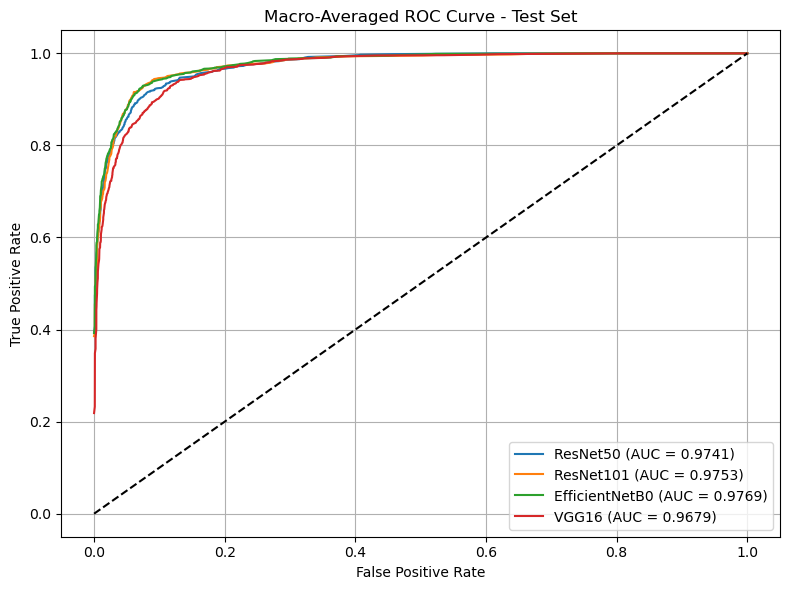

In [63]:
results_test = {
    "ResNet50": results_test_resnet50,
    "ResNet101": results_test_resnet101,
    "EfficientNetB0": results_test_EfficientNetB0,
    "VGG16": results_test_VGG16
}
plot_roc_curves(results_test, title="Macro-Averaged ROC Curve - Test Set")

#### Execution Time Comparison

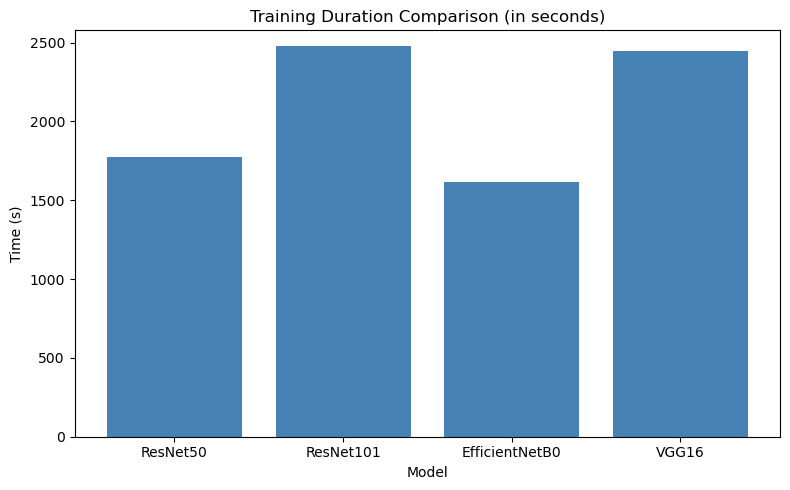

In [65]:
model_names = ["ResNet50", "ResNet101", "EfficientNetB0", "VGG16"]
durations = [training_duration_resnet_50,
             training_duration_resnet_101,
             training_duration_EfficientNetB0,
             training_duration_VGG16]

plt.figure(figsize=(8, 5))
plt.bar(model_names, durations, color='steelblue')
plt.title("Training Duration Comparison (in seconds)")
plt.ylabel("Time (s)")
plt.xlabel("Model")
plt.ylim(0, max(durations) + 100)
plt.tight_layout()
plt.show()

<ul> <li><b>EfficientNetB0</b> not only delivered the <b>best accuracy and F1 score</b> across validation and test sets, but also did so with the <b>shortest training time</b>. This makes it the most efficient and accurate model overall.</li> <li><b>ResNet101</b> had slightly better test recall than ResNet50 and VGG16, but required the longest training time, reducing its practical efficiency.</li> <li><b>VGG16</b> had the worst generalization performance and also one of the longest training times, making it the least favorable in this experiment.</li> <li><b>ResNet50</b> was a good trade-off between accuracy and speed, but slightly behind EfficientNetB0 in both aspects.</li> </ul>

<b>References and Citations</b>
<ul>
    <li>Pedregosa et al., "Scikit-learn: Machine Learning in Python", Journal of Machine Learning Research, 2011</li>
    <li>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html</li>
    <li>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html</li>
    <li>https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html</li>
    <li>https://keras.io/api/applications/ - Keras Applications: Pretrained Models (ResNet50, ResNet101, EfficientNetB0, VGG16)</li>
    <li>https://www.tensorflow.org/api_docs - TensorFlow API Documentation</li>
    <li>https://matplotlib.org/stable/gallery/index.html - Matplotlib Visualizations</li>
    <li>https://seaborn.pydata.org/examples/index.html - Seaborn Statistical Data Visualization</li>
    <li>Hastie, Tibshirani, and Friedman. "The Elements of Statistical Learning", Springer, 2009 </li>
    <li>https://builtin.com/data-science/transfer-learning</li>
    <li>https://en.wikipedia.org/wiki/Batch_normalization</li>
</ul>